## Loading Libraries

In [48]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [49]:
import pandas as pd
import glob
import os
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import  Dropout
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import chi2_contingency
import lightgbm as lgb
import networkx as nx
import warnings

In [50]:
warnings.filterwarnings('ignore')

In [88]:
df = pd.read_csv(r"C:\Users\attafuro\Desktop\EV Charging Analysis\cleaned_traffic_data.csv")

In [52]:
df. head()

,Timestamp,Station,District,Route,Direction of Travel,Lane Type,Station Length,Samples,% Observed,Total Flow,...,Lane 5 Avg Speed,Lane 6 Flow,Lane 6 Avg Occ,Lane 6 Avg Speed,Lane 7 Flow,Lane 7 Avg Occ,Lane 7 Avg Speed,Lane 8 Flow,Lane 8 Avg Occ,Lane 8 Avg Speed
0,10/01/2024 00:00:00,308512,3,50,W,ML,3.995,197,0,497.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10/01/2024 00:00:00,311831,3,5,S,OR,NaN,101,92,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10/01/2024 00:00:00,311832,3,5,S,FR,NaN,101,92,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10/01/2024 00:00:00,311844,3,5,N,OR,NaN,202,92,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10/01/2024 00:00:00,311847,3,5,N,OR,NaN,303,92,73.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
df.shape

(4114680, 42)

## Basic Exploration 

In [89]:
# Define the final selected columns
selected_columns = [
    "Timestamp", "Station", "Route", "Direction of Travel",
    "Total Flow", "Avg Speed", "% Observed","Samples","Lane Type"
]

# Keep only the selected columns
df = df[selected_columns]

In [55]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,Avg Speed,% Observed,Samples,Lane Type
0,10/01/2024 00:00:00,308512,50,W,497.0,64.1,0,197,ML
1,10/01/2024 00:00:00,311831,5,S,27.0,NaN,92,101,OR
2,10/01/2024 00:00:00,311832,5,S,78.0,NaN,92,101,FR
3,10/01/2024 00:00:00,311844,5,N,43.0,NaN,92,202,OR
4,10/01/2024 00:00:00,311847,5,N,73.0,NaN,92,303,OR


In [56]:
df.isna().sum()

Timestamp                    0
Station                      0
Route                        0
Direction of Travel          0
Total Flow              303776
Avg Speed              1582594
% Observed                   0
Samples                      0
Lane Type                    0
dtype: int64

In [90]:
df.drop(columns=["Avg Speed"], inplace=True)

In [58]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type
0,10/01/2024 00:00:00,308512,50,W,497.0,0,197,ML
1,10/01/2024 00:00:00,311831,5,S,27.0,92,101,OR
2,10/01/2024 00:00:00,311832,5,S,78.0,92,101,FR
3,10/01/2024 00:00:00,311844,5,N,43.0,92,202,OR
4,10/01/2024 00:00:00,311847,5,N,73.0,92,303,OR


In [59]:
df.isna().sum()

Timestamp                   0
Station                     0
Route                       0
Direction of Travel         0
Total Flow             303776
% Observed                  0
Samples                     0
Lane Type                   0
dtype: int64

In [91]:
df = df[df['Total Flow'].notna()]

In [61]:
df.isna().sum()

Timestamp              0
Station                0
Route                  0
Direction of Travel    0
Total Flow             0
% Observed             0
Samples                0
Lane Type              0
dtype: int64

In [92]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type
0,10/01/2024 00:00:00,308512,50,W,497.0,0,197,ML
1,10/01/2024 00:00:00,311831,5,S,27.0,92,101,OR
2,10/01/2024 00:00:00,311832,5,S,78.0,92,101,FR
3,10/01/2024 00:00:00,311844,5,N,43.0,92,202,OR
4,10/01/2024 00:00:00,311847,5,N,73.0,92,303,OR


In [63]:
df.dtypes

Timestamp               object
Station                  int64
Route                    int64
Direction of Travel     object
Total Flow             float64
% Observed               int64
Samples                  int64
Lane Type               object
dtype: object

In [64]:
df.duplicated().sum()

0

In [65]:
df.reset_index().duplicated(subset=['Timestamp', 'Station']).sum()

0

In [99]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
df.sort_index(inplace=True)

In [100]:
# Convert Station to categorical type
df['Station'] = df['Station'].astype('category')

In [101]:
df.head()

,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type
Timestamp,,,,,,,
2024-10-01,308512,50,W,497.0,0,197,ML
2024-10-01,311831,5,S,27.0,92,101,OR
2024-10-01,311832,5,S,78.0,92,101,FR
2024-10-01,311844,5,N,43.0,92,202,OR
2024-10-01,311847,5,N,73.0,92,303,OR


## Feature Engineering

In [102]:
df['Hour'] = df.index.hour
df['Day'] = df.index.day
df['Weekday'] = df.index.weekday
df['IsWeekend'] = df['Weekday'].isin([5, 6]).astype(int)

In [103]:
for lag in range(1, 73):  # Lags 1 to 72
    df[f'TotalFlow_lag_{lag}'] = df['Total Flow'].shift(lag)

# Drop the rows that now have NaNs in these lag features (first 72 rows)
df.dropna(inplace=True)

In [104]:
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Weekday_sin'] = np.sin(2 * np.pi * df['Weekday'] / 7)
df['Weekday_cos'] = np.cos(2 * np.pi * df['Weekday'] / 7)

In [105]:
df['Flow_roll_mean_6h'] = df['Total Flow'].rolling(window=6).mean()
df['Flow_roll_std_6h'] = df['Total Flow'].rolling(window=6).std()
df['Flow_roll_max_6h'] = df['Total Flow'].rolling(window=6).max()
df['Flow_roll_min_6h'] = df['Total Flow'].rolling(window=6).min()

In [106]:
for window in [3, 12, 24, 48, 72]:
    df[f'Flow_mean_{window}'] = df['Total Flow'].rolling(window=window).mean()
    df[f'Flow_std_{window}'] = df['Total Flow'].rolling(window=window).std()
    df[f'Flow_min_{window}'] = df['Total Flow'].rolling(window=window).min()
    df[f'Flow_max_{window}'] = df['Total Flow'].rolling(window=window).max()

In [107]:
df.dropna(inplace=True)

In [108]:
custom_holidays = [
    pd.to_datetime("2024-12-25"),
    pd.to_datetime("2024-12-31"),
    pd.to_datetime("2024-11-24"),
]
df['IsHoliday'] = df.index.to_series().apply(lambda x: 1 if x in custom_holidays else 0)

In [109]:
df.head()

,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type,Hour,Day,Weekday,...,Flow_max_24,Flow_mean_48,Flow_std_48,Flow_min_48,Flow_max_48,Flow_mean_72,Flow_std_72,Flow_min_72,Flow_max_72,IsHoliday
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-01,313344,50,W,190.0,92,202,ML,0,1,1,...,1068.0,395.833333,570.838627,3.0,3419.0,435.736111,522.596712,3.0,3419.0,0
2024-10-01,313349,50,W,190.0,92,202,ML,0,1,1,...,1068.0,399.458333,568.924516,3.0,3419.0,437.486111,521.544267,3.0,3419.0,0
2024-10-01,313368,80,W,787.0,100,719,ML,0,1,1,...,1068.0,404.375000,571.276906,3.0,3419.0,440.069444,522.824677,3.0,3419.0,0
2024-10-01,313386,80,W,1050.0,92,404,ML,0,1,1,...,1068.0,426.000000,575.736716,3.0,3419.0,443.555556,526.078366,3.0,3419.0,0
2024-10-01,313393,80,E,1064.0,92,505,ML,0,1,1,...,1068.0,376.937500,383.507686,3.0,1525.0,457.500000,529.066225,3.0,3419.0,0


In [110]:
for window in [12, 24, 48, 72]:
    df[f'Flow_CV_{window}'] = df[f'Flow_std_{window}'] / df[f'Flow_mean_{window}']

In [111]:
df.dropna(inplace=True)

In [112]:
# Group by station and calculate mean and std of Total Flow
station_stats = df.groupby('Station')['Total Flow'].agg(['mean', 'std'])
station_stats['CV'] = station_stats['std'] / station_stats['mean']
station_stats.dropna(inplace=True)  

## Basic Graphical Exploration

In [113]:
df['IsHoliday'] = df['IsHoliday'].astype('category')
df['Route'] = df['Route'].astype('category')

In [114]:
#  Keep only numeric features
numeric_df = df.select_dtypes(include='number')

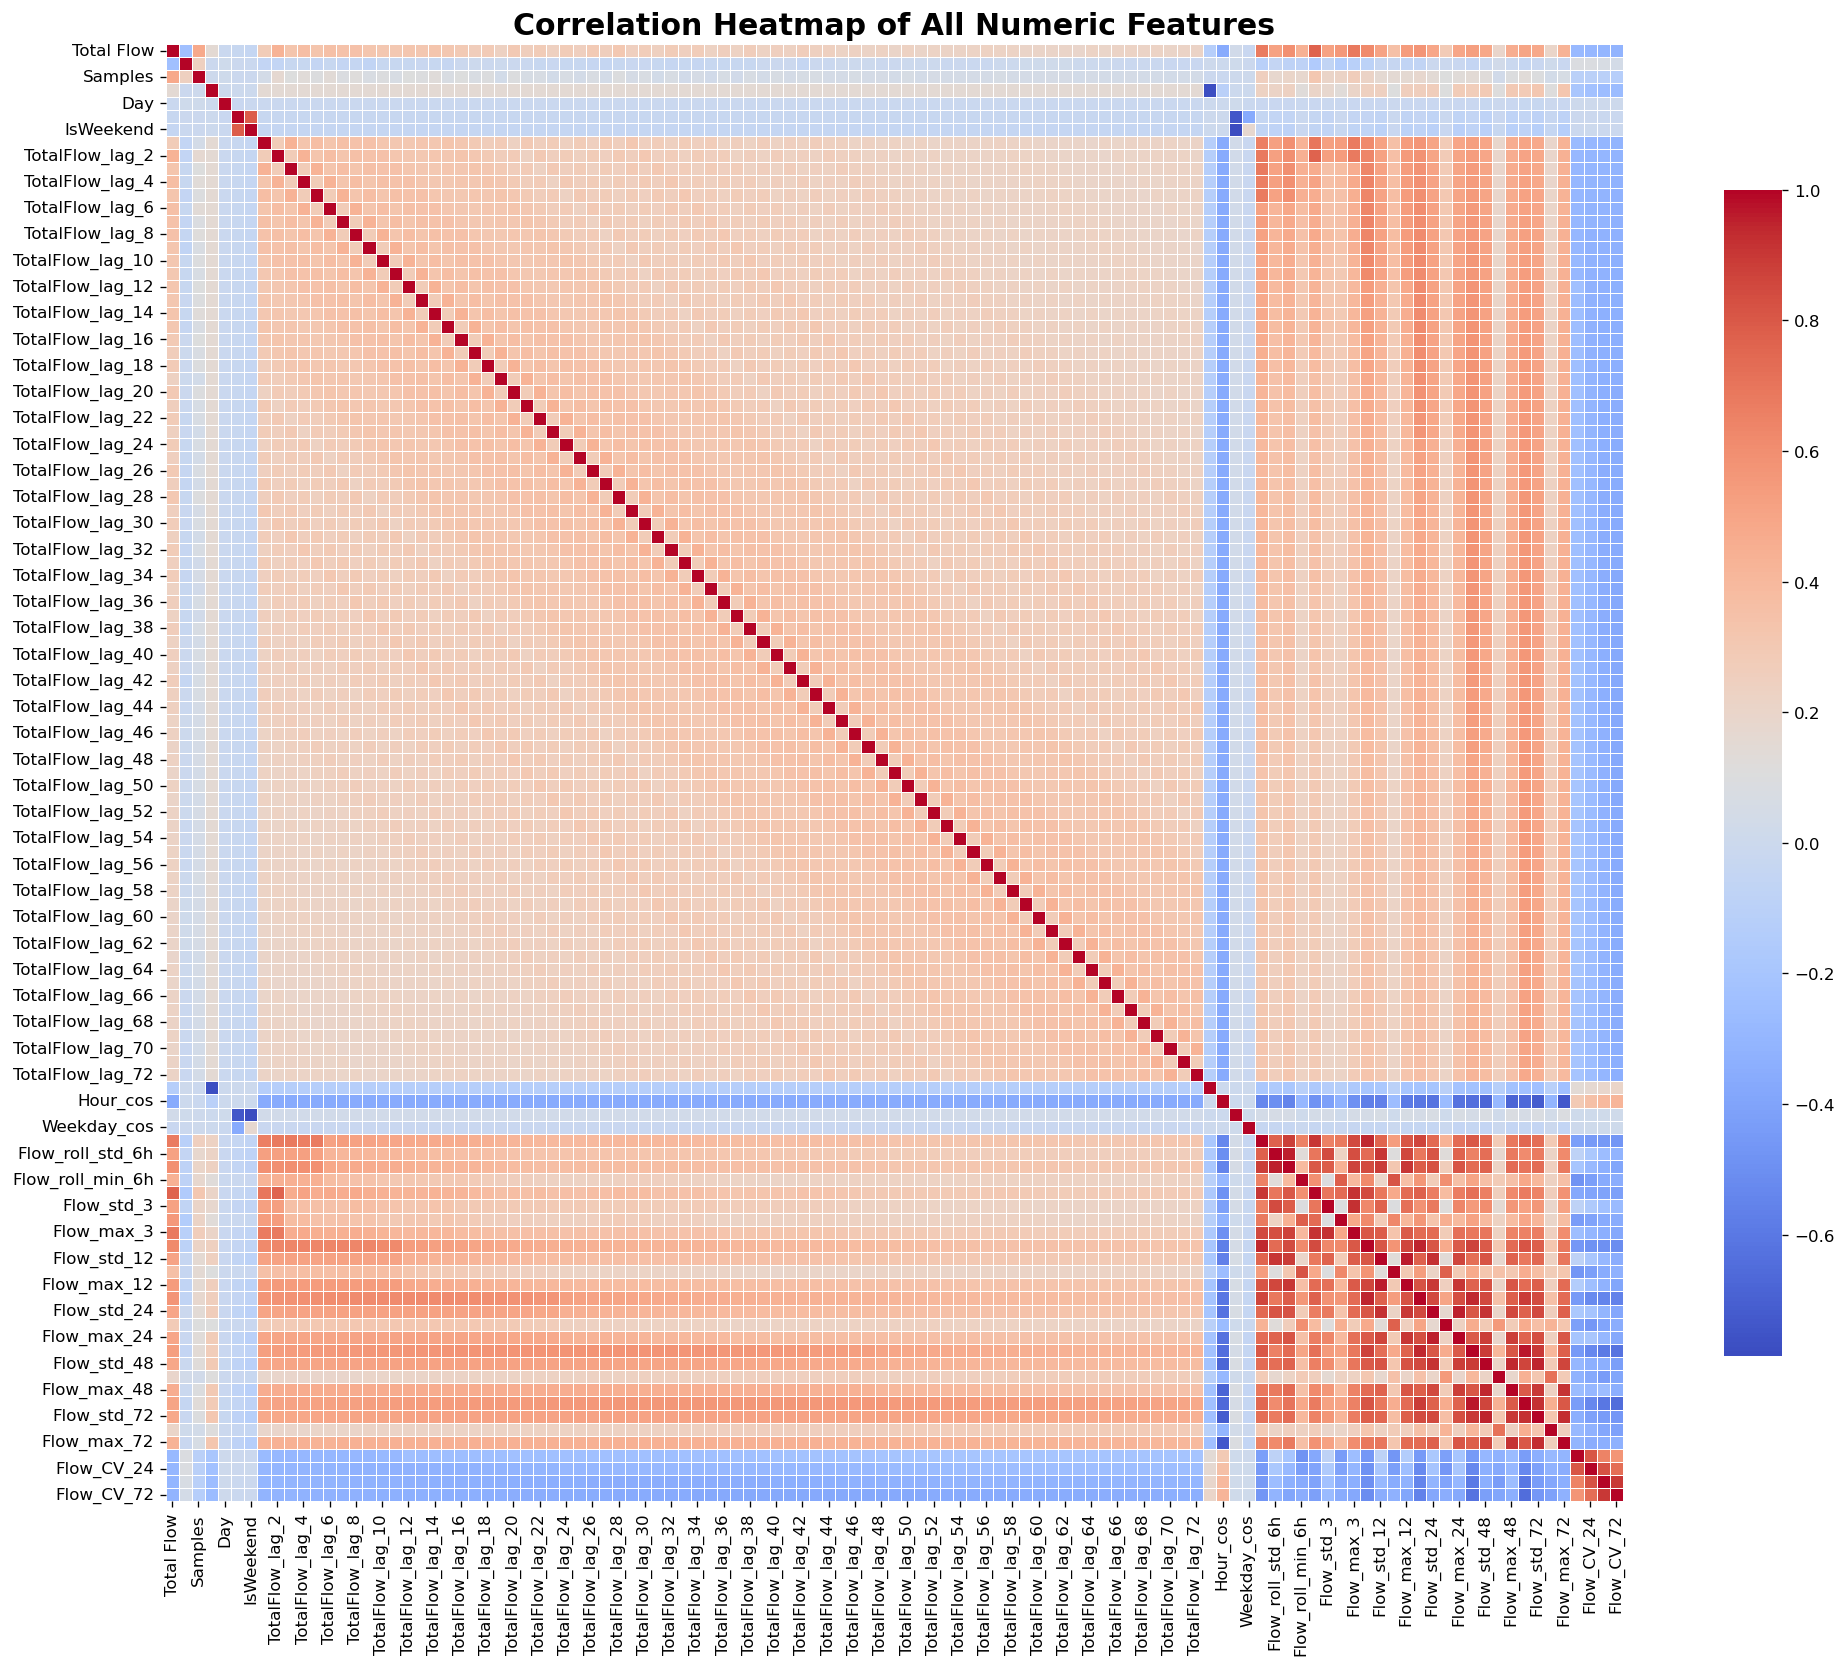

In [82]:
# Plot full correlation matrix
plt.figure(figsize=(18, 14), dpi=120)
corr_matrix = numeric_df.corr()

sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, fmt=".2f",
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title("Correlation Heatmap of All Numeric Features", fontsize=18, fontweight='bold')
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [115]:
cat_features = [
    'Station', 'Route', 'Direction of Travel', 'Lane Type',
    'Weekday', 'IsWeekend', 'IsHoliday'
]

for col in cat_features:
    df[col] = df[col].astype('category')

In [116]:
# Define target and features
target = 'Total Flow'
features = [col for col in df.columns if col != target]

In [117]:
# Final feature groups
flow_features = [
    'Flow_mean_3', 'Flow_std_3', 'Flow_max_3', 'Flow_min_3',
    'Flow_mean_72', 'Flow_std_72', 'Flow_std_48', 'Flow_max_24',
    'Flow_mean_24', 'Flow_mean_48',
    'Flow_roll_std_6h', 'Flow_roll_max_6h',
    'Flow_CV_48'
]

lag_features = [
    'TotalFlow_lag_1', 'TotalFlow_lag_2', 'TotalFlow_lag_3',
    'TotalFlow_lag_7', 'TotalFlow_lag_8',
    'TotalFlow_lag_15', 'TotalFlow_lag_18'
]

time_features = [
    'Hour', 'Hour_cos', 'Hour_sin', 'Weekday_cos'
]

quality_features = [
    'Samples', '% Observed'
]

# Copy original DataFrame
df_model = df.copy()

# One-hot encode low-cardinality features
df_model = pd.get_dummies(df_model, columns=['IsHoliday', 'Direction of Travel'], drop_first=True)

# Label encode high-cardinality categorical features
for col in ['Station', 'Route', 'Lane Type']:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])

# Capture dummy columns dynamically
dummy_columns = [col for col in df_model.columns if col.startswith('IsHoliday_') or col.startswith('Direction of Travel_')]

# Final feature list
categorical_features = ['Lane Type', 'Route', 'Station']
selected_features = flow_features + lag_features + time_features + quality_features + categorical_features + dummy_columns


# Graph Based Models 

In [121]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Build CV Graph using vectorized pairwise differences
cv_df = df.groupby('Station')['Flow_CV_48'].mean().reset_index()
stations = cv_df['Station'].values
cv_values = cv_df['Flow_CV_48'].values

# Compute absolute pairwise distances
dist_matrix = squareform(pdist(cv_values[:, None], metric='cityblock'))

# Build graph with edges where diff <= threshold
threshold = 0.5
G = nx.Graph()
G.add_nodes_from(stations)

for i in range(len(stations)):
    for j in range(i + 1, len(stations)):
        if dist_matrix[i, j] <= threshold:
            G.add_edge(stations[i], stations[j])

# Build neighbor lookup
neighbor_map = {station: list(G.neighbors(station)) for station in G.nodes}

# Define lag features
lag_features = [
    'TotalFlow_lag_1', 'TotalFlow_lag_2', 'TotalFlow_lag_3',
    'TotalFlow_lag_7', 'TotalFlow_lag_8', 'TotalFlow_lag_15', 'TotalFlow_lag_18'
]

# Merge neighbor lags
df_extended = []
for station in df['Station'].unique():
    station_df = df[df['Station'] == station].copy()
    neighbors = neighbor_map.get(station, [])

    for neighbor in neighbors:
        neighbor_df = df[df['Station'] == neighbor].reset_index()
        neighbor_df.rename(columns={'index': 'Timestamp'}, inplace=True)
        neighbor_df = neighbor_df[['Timestamp'] + lag_features].copy()


    station_df['StationID'] = station
    df_extended.append(station_df)

df_extended = pd.concat(df_extended, ignore_index=True)

#  Build Design Matrix
own_lags = lag_features
all_neighbor_lags = [f'{n}_{lag}' for n in df['Station'].unique() for lag in lag_features]
X_cols = [col for col in df_extended.columns if col in own_lags or col in all_neighbor_lags]
X = df_extended[X_cols].copy()
y = df_extended['Total Flow'].copy()

# Drop NaNs and Split
X = X.dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression and Evaluate
model_cv_lr = LinearRegression()
model_cv_lr.fit(X_train, y_train)
y_pred = model_cv_lr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("CV-Based Linear Regression (CV-LR) Results:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


CV-Based Linear Regression (CV-LR) Results:
MAE: 765.31
RMSE: 1112.88


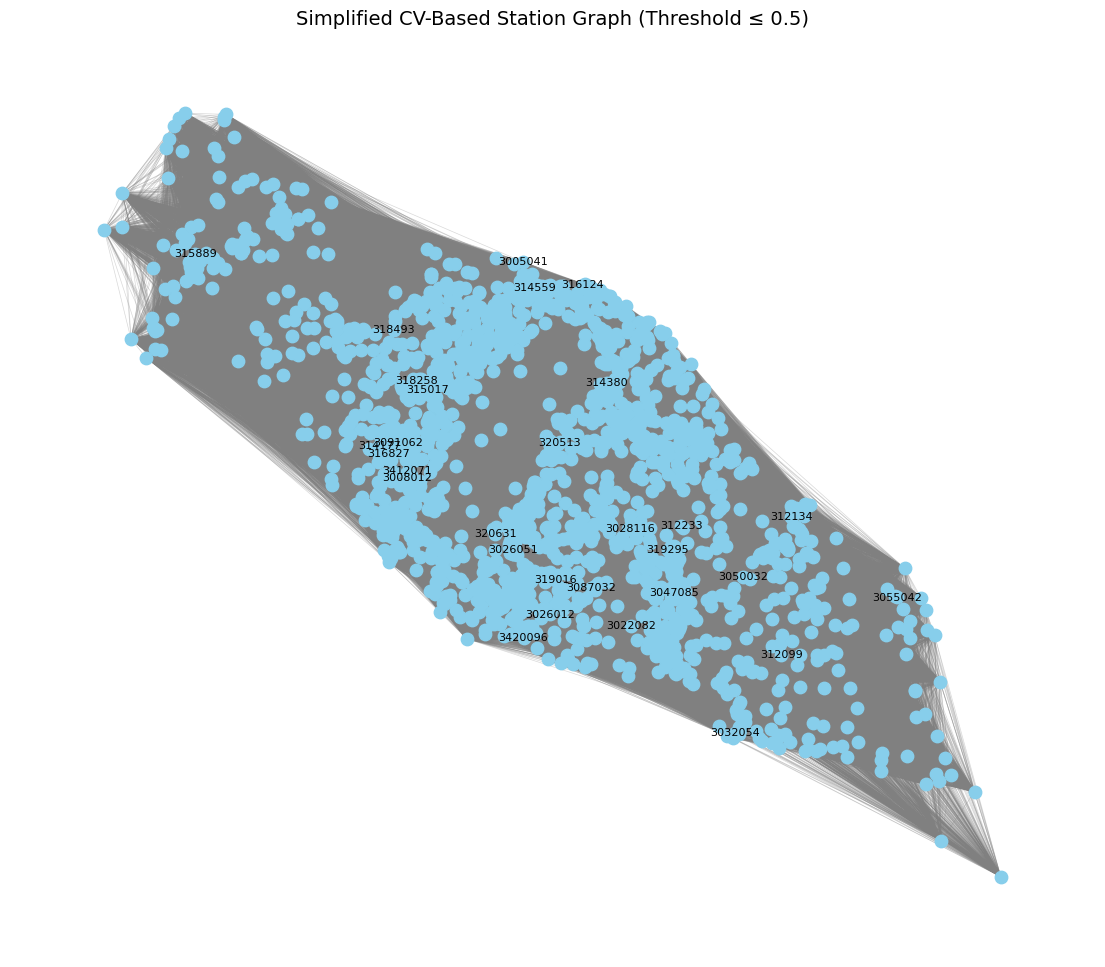

In [122]:
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G, seed=42)  # layout with fixed seed

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=80)
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.3, width=0.5)

import random
label_sample = random.sample(list(G.nodes), 30)
labels = {node: str(node) for node in label_sample}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

plt.title("Simplified CV-Based Station Graph (Threshold ≤ 0.5)", fontsize=14)
plt.axis('off')
plt.show()